![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/Spark_NLP_Udemy_MOOC/Open_Source/13.01.GraphExtraction_&_GraphFinisher.ipynb)

# Graph Extraction

In Spark NLP, the `GraphExtraction` annotator can create graph representation of entities based on the gramatical relation between the tokens of the sentence, and the `GraphFinisher` can transform `NODE` annotations into RDF (triplets) format.


**📖 Learning Objectives:**

1. Be able to create graph representation of tokens and named entities.

2. Become comfortable using the different parameters of the `GraphExtraction` and `GraphFinisher` annotators.

3. Transform the extracted graph annotaiton to RDF format using the `GraphFinisher` annotator.


**🔗 Helpful Links:**

- Documentation : [GraphExtraction](https://sparknlp.org/docs/en/annotators#graphextraction), [GraphFinisher](https://sparknlp.org/docs/en/annotators#graphfinisher)

- Python Docs : [GraphExtraction](https://sparknlp.org/docs/en/annotators#graphextraction), [GraphFinisher](https://sparknlp.org/api/python/reference/autosummary/sparknlp/base/graph_finisher/index.html#sparknlp.base.graph_finisher.GraphFinisher)

- Scala Docs : [GraphExtraction](https://sparknlp.org/api/com/johnsnowlabs/nlp/annotators/GraphExtraction), [GraphFinisher](https://sparknlp.org/api/com/johnsnowlabs/nlp/GraphFinisher)

- For extended examples of usage, see the [Spark NLP Workshop repository](https://github.com/JohnSnowLabs/spark-nlp-workshop/tree/master/open-source-nlp/).


## **📜 Background**

The `GraphExtraction` creates a graph representation of tokens and entities where **Nodes** represent the entities and the **edges** represent the relations between those entities.


The `GraphFinisher` annotator transforms the annotations generated by `GraphExtraction` into RDF format.

## **🎬 Colab Setup**

In [ ]:
# Install libraries
! pip install -q pyspark==3.2.3 spark-nlp==4.4.0 spark-nlp-display

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.5/281.5 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.4/486.4 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.6/95.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.6 MB/s eta 0:00:00


In [ ]:
import sparknlp
from sparknlp.base import GraphFinisher, DocumentAssembler, Pipeline, LightPipeline
from sparknlp.annotator import (
    GraphExtraction,
    Tokenizer,
    PerceptronModel,
    DependencyParserModel,
    TypedDependencyParserModel,
    WordEmbeddingsModel,
    NerDLModel,
    NerConverter,
)
from sparknlp_display import DependencyParserVisualizer, NerVisualizer
from pyspark.sql import functions as F


spark = sparknlp.start()

## **🖨️ Input/Output Annotation Types**


- Input: `DOCUMENT`, `TOKEN`, `NAMED_ENTITY`

- Output: `NODE`

## **🔎 Parameters**

- `relationshipTypes` *(List[str])*: List of possible relations between tokens and entities to be extracted from the dependency tree.
- `entityTypes` *(List[str])*: List of entities to create relations between them.
- `explodeEntities` *(Boolean)*: Whether to find paths between entities.
- `rootTokens` *(List[str])*: Tokens to be considered as the root to start traversing the paths. Use it along with `explodeEntities`.
- `maxSentenceSize` *(Integer)*: Maximum sentence size that the annotator will process, by default 1000. Above this, the sentence is skipped.
- `minSentenceSize` *(Integer)*: Minimum sentence size that the annotator will process, by default 2. Below this, the sentence is skipped.
- `mergeEntities` *(Boolean)*: Whether to merge entities that are in IOB/IOB2 format as a single token. E.g., `B-Peter` and `I-Parker` would become `Peter Parker`.
- `mergeEntitiesIOBFormat` *(String)*: IOB format to apply when merging entities. Either IOB or IOB2.
- `includeEdges` *(Boolean)*: Whether to include edges when building paths.
- `delimiter` *(String)*: Delimiter symbol used for path output.
- `posModel` *(List[String])*: Coordinates (name, lang, remoteLoc) to a pretrained POS model.
- `dependencyParserModel` *(List[String])*: Coordinates (name, lang, remoteLoc) to a pretrained Dependency Parser model.
- `typedDependencyParserModel` *(List[String])*: Coordinates (name, lang, remoteLoc) to a pretrained Typed Dependency Parser model.



##  First Steps

The annotator is based on the outputs of `DependencyParser` and `TypedDependencyParser` to find the paths between entities and tokens. We will first create a base pipeline with the required annotations.

In [ ]:
document_assembler = DocumentAssembler().setInputCol("text").setOutputCol("document")

tokenizer = Tokenizer().setInputCols(["document"]).setOutputCol("token")

pos_tagger = (
    PerceptronModel.pretrained().setInputCols("document", "token").setOutputCol("pos")
)
dep_parser = (
    DependencyParserModel.pretrained()
    .setInputCols(["document", "pos", "token"])
    .setOutputCol("dependency")
)
typed_dep_parser = (
    TypedDependencyParserModel.pretrained()
    .setInputCols(["token", "pos", "dependency"])
    .setOutputCol("dependency_type")
)

word_embeddings = (
    WordEmbeddingsModel.pretrained()
    .setInputCols(["document", "token"])
    .setOutputCol("embeddings")
)

ner_tagger = (
    NerDLModel.pretrained("ner_dl", "en")
    .setInputCols(["document", "token", "embeddings"])
    .setOutputCol("ner")
)
converter = (
    NerConverter()
    .setInputCols(["document", "token", "ner"])
    .setOutputCol("ner_chunk")
)

base_pipeline = Pipeline().setStages(
    [document_assembler, tokenizer, pos_tagger, dep_parser, typed_dep_parser, word_embeddings, ner_tagger, converter]
)

empty_df = spark.createDataFrame([['']]).toDF("text")
base_model = base_pipeline.fit(empty_df)

pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[OK!]
dependency_typed_conllu download started this may take some time.
Approximate size to download 2.4 MB
[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]
ner_dl download started this may take some time.
Approximate size to download 13.6 MB
[OK!]


The `GraphExtraction` choses paths present on the dependecy tree. One example of dependency tree can be seen below.

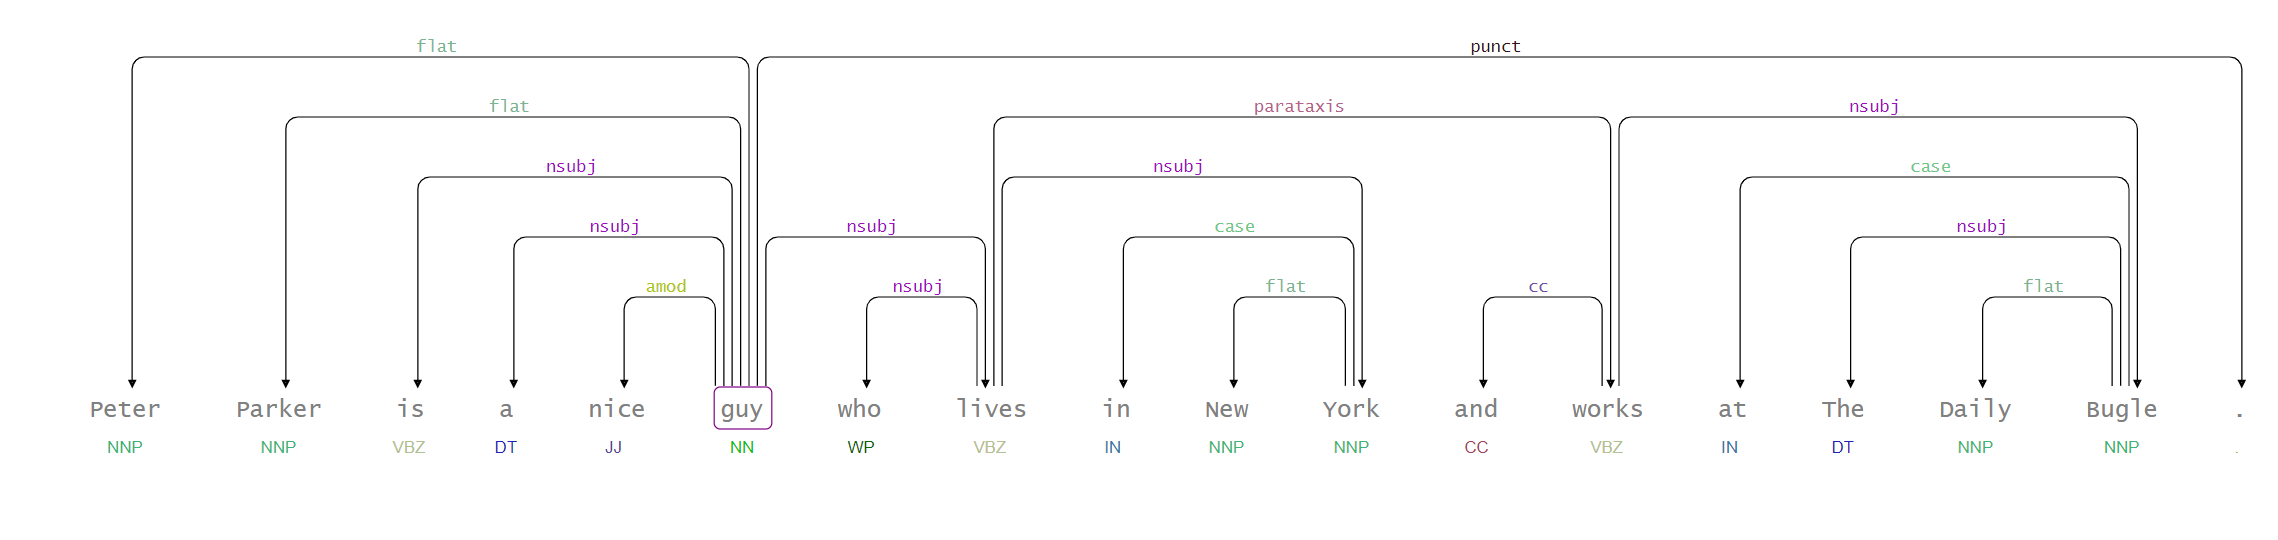

Visualizing the identified entities.

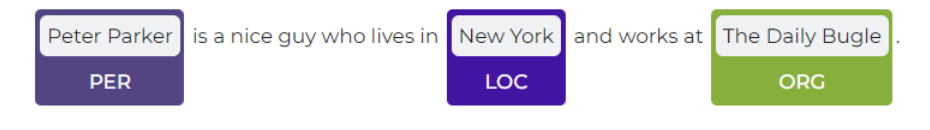

In [ ]:
data_set = spark.createDataFrame(
    [["Peter Parker is a nice guy who lives in New York and works at The Daily Bugle."]]
).toDF("text")

graph_df = base_model.transform(data_set)

## `mergeEntities`

With `mergeEntities=False`, we see that each word of the entities is used in the paths.

In [ ]:
graph_extraction = (
    GraphExtraction()
    .setInputCols(["document", "token", "ner"])
    .setOutputCol("graph")
    .setMergeEntities(False)
)

In [ ]:
graph_extraction.transform(graph_df).select("graph").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Setting it to `True` will merge them:

In [ ]:
graph_extraction.setMergeEntities(True).transform(graph_df).select("graph").show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|graph                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
+-------------------------------------------

We have paths that contains `PER,LOC`, `PER,ORG` and `LOC,ORG` entities.

## `RelationshipTypes`

We can set the relation types we want to extract paths. To use this parameter, `explodeEntities` should be set to `False`. Let's see how to set the relations to contain only `PER` or `LOC` entities. Note that `guy` is the root word of the dependency tree.

In [ ]:
graph_extraction = (
    GraphExtraction()
    .setInputCols(["document", "token", "ner"])
    .setOutputCol("graph")
    .setMergeEntities(True)
    .setExplodeEntities(False)
)

In [ ]:
graph_extraction.setRelationshipTypes(["guy-LOC"]).transform(graph_df).select("graph").show(truncate=False)

+---------------------------------------------------------------------------------------------+
|graph                                                                                        |
+---------------------------------------------------------------------------------------------+
|[{node, 23, 25, guy, {relationship -> guy,LOC, path1 -> guy,nsubj,lives,nsubj,New York}, []}]|
+---------------------------------------------------------------------------------------------+



In [ ]:
graph_extraction.setRelationshipTypes(["guy-PER"]).transform(graph_df).select("graph").show(truncate=False)

+------------------------------------------------------------------------------------+
|graph                                                                               |
+------------------------------------------------------------------------------------+
|[{node, 23, 25, guy, {relationship -> guy,PER, path1 -> guy,flat,Peter Parker}, []}]|
+------------------------------------------------------------------------------------+



## `explodeEntities`
When setting `explodeEntities` to True, Graph Extraction will find paths between all possible pair of entities.

In [ ]:
graph_extraction.setExplodeEntities(True).transform(graph_df).select("graph").show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|graph                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
+-------------------------------------------

## `rootTokens`
We set this parameter to set tokens which are considered as the root to start traversing the paths. To define a root that will return meaningful relationships, a token has to fulfill the following requirements:
1. It has to have an ancestor node
2. It has to have descendants
3. It has to have at least one descendant node labeled as entity by NER

The default root word is `guy`, let's change it to `lives`.

In [ ]:
graph_extraction.setRootTokens(["lives"]).transform(graph_df).select("graph").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------+
|graph                                                                                                                                                          |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[{node, 31, 35, lives, {entities -> LOC,ORG, left_path -> lives,nsubj,New York, right_path -> lives,nsubj,New York,parataxis,works,nsubj,The Daily Bugle}, []}]|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------+



## `EntityTypes`

 Filter paths that contains the given NER entities on either `left_path` or `right_path`. The format is hyphen separated entities, e.g., `["PER-ORG"]`.

In [ ]:
graph_extraction.setRootTokens(["guy"]).setEntityTypes(["PER-ORG"]).transform(graph_df).select("graph").show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|graph                                                                                                                                                                   |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[{node, 23, 25, guy, {entities -> PER,ORG, left_path -> guy,flat,Peter Parker, right_path -> guy,nsubj,lives,nsubj,New York,parataxis,works,nsubj,The Daily Bugle}, []}]|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------+



In [ ]:
graph_extraction.setEntityTypes(["LOC-ORG"]).transform(graph_df).select("graph").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|graph                                                                                                                                                                            |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[{node, 23, 25, guy, {entities -> LOC,ORG, left_path -> guy,nsubj,lives,nsubj,New York, right_path -> guy,nsubj,lives,nsubj,New York,parataxis,works,nsubj,The Daily Bugle}, []}]|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+



## `includeEdges`
We set this parameter to choose whether to include edges(relationship types) when building paths. By default, it is set to `True`. Let's set it to `False`.

In [ ]:
graph_extraction.setIncludeEdges(False).transform(graph_df).select("graph").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------+
|graph                                                                                                                                    |
+-----------------------------------------------------------------------------------------------------------------------------------------+
|[{node, 23, 25, guy, {entities -> LOC,ORG, left_path -> guy,lives,New York, right_path -> guy,lives,New York,works,The Daily Bugle}, []}]|
+-----------------------------------------------------------------------------------------------------------------------------------------+



## `delimiter`
We set this parameter to specify a delimiter symbol which can be used for path output. De default value is comman `,`, let's change it to `~`.


In [ ]:
graph_extraction.setDelimiter('~').transform(graph_df).select("graph").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------+
|graph                                                                                                                                    |
+-----------------------------------------------------------------------------------------------------------------------------------------+
|[{node, 23, 25, guy, {entities -> LOC,ORG, left_path -> guy~lives~New York, right_path -> guy~lives~New York~works~The Daily Bugle}, []}]|
+-----------------------------------------------------------------------------------------------------------------------------------------+



## `mergeEntitiesIOBFormat`

We choose which IOB format to apply when merging entities. There are 2 options:  IOB or IOB2. This will depend on the format used by the NER model. In our example (`ner_dl`), the format used is `IOB2`.

In [ ]:
graph_extraction.setMergeEntitiesIOBFormat("IOB2").setMergeEntities(True).transform(graph_df).select("graph").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------+
|graph                                                                                                                                    |
+-----------------------------------------------------------------------------------------------------------------------------------------+
|[{node, 23, 25, guy, {entities -> LOC,ORG, left_path -> guy~lives~New York, right_path -> guy~lives~New York~works~The Daily Bugle}, []}]|
+-----------------------------------------------------------------------------------------------------------------------------------------+



## `posModel`, `dependencyParserModel` and `typedDependencyParserModel`

Use these parameters to set different POS, Dependency Parser and Typed Dependecy Parser models to use internally if not set on the pipeline.

In [ ]:
document_assembler = DocumentAssembler().setInputCol("text").setOutputCol("document")

tokenizer = Tokenizer().setInputCols(["document"]).setOutputCol("token")

word_embeddings = (
    WordEmbeddingsModel.pretrained()
    .setInputCols(["document", "token"])
    .setOutputCol("embeddings")
)

ner_tagger = (
    NerDLModel.pretrained("ner_dl", "en")
    .setInputCols(["document", "token", "embeddings"])
    .setOutputCol("ner")
)

pipeline = Pipeline().setStages(
    [document_assembler, tokenizer, word_embeddings, ner_tagger]
)

empty_df = spark.createDataFrame([['']]).toDF("text")
model = base_pipeline.fit(empty_df)

graph_df2 = model.transform(data_set)

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]
ner_dl download started this may take some time.
Approximate size to download 13.6 MB
[OK!]


In [ ]:
graph_extraction = (
    GraphExtraction()
    .setInputCols(["document", "token", "ner"])
    .setOutputCol("graph")
    .setMergeEntities(False) # Need to set this to False
    .setPosModel(["pos_ud", "en"]) # A new POS model
    .setDependencyParserModel(["dependency_conllu", "en"]) # Only one available in NLP Models Hub
    .setTypedDependencyParserModel(["dependency_typed_conllu", "en"]) # Only one available in NLP Models Hub
)

In [ ]:
graph_extraction.transform(graph_df2).select("graph").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## `maxSentenceSize` and `minSentenceSize`

Filter the sentences that have length between the minumum and maximim sizes (defaults are 1200 and 0).

In [ ]:
new_data = spark.createDataFrame([
    ["Peter Parker is a nice guy who lives in New York."], # size = 49
    ["Peter Parker is a nice guy who lives in New York and works at The Daily Bugle."] # size = 78
]).toDF("text")

new_data = base_model.transform(new_data)

In [ ]:
graph_extraction = (
    GraphExtraction()
    .setInputCols(["document", "token", "ner"])
    .setOutputCol("graph")
    .setMergeEntities(True)
)

In [ ]:
# Process the first sentence only
graph_extraction.setMaxSentenceSize(50).setMinSentenceSize(1).transform(new_data).select("graph").show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------+
|graph                                                                                                                             |
+----------------------------------------------------------------------------------------------------------------------------------+
|[{node, 23, 25, guy, {entities -> PER,LOC, left_path -> guy,flat,Peter Parker, right_path -> guy,nsubj,lives,nsubj,New York}, []}]|
|[{node, 0, 0, , {}, []}]                                                                                                          |
+----------------------------------------------------------------------------------------------------------------------------------+



In [ ]:
# Process the second sentence only
graph_extraction.setMaxSentenceSize(80).setMinSentenceSize(50).transform(new_data).select("graph").show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|graph                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
+-------------------------------------------

## `GraphFinisher`

This annotator transforms the `NODE` annotations into RDF format.

## **🖨️ Input/Output Annotation Types**

- Input: `NODE`

- Output: `NONE` (RDF format, not an annotation)

## **🔎 Parameters**

- `cleanAnnotations` *(Boolean)*: Whether to remove all the existing annotation columns, by default True.
- `outputAsArray` *(Boolean)*: Whether to generate an Array with the results, by default True.

In [ ]:
graph_finisher = (
    GraphFinisher()
    .setInputCol("graph")
    .setOutputCol("rdf")
)

In [ ]:
graph_df = graph_extraction.transform(graph_df)

## `cleanAnnotations`

When set to `True`, all other columns in the data frame are dropped.

In [ ]:
graph_finisher.setCleanAnnotations(True).transform(graph_df).show(truncate=False)

+------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                          |rdf                                                                                                                                                                                                                                                                                                                                                                                         |
+---------------------------------------------------------------------------

When set to false, the columns remain in the data frame.

In [ ]:
graph_finisher.setCleanAnnotations(False).transform(graph_df).show(truncate=False)

+------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------

## `outputAsArray`

If set to `True`, the outputs are arrays with the three elements: token, edge, and entity.

In [ ]:
graph_finisher.setOutputAsArray(True).transform(graph_df).select("rdf").show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|rdf                                                                                                                                                                                                                                                                                                                                                                                         |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

If set to `False`, the elements are strings in the format `'("TOKEN", "EDGE", "ENTITY")'`

In [ ]:
graph_finisher.setOutputAsArray(False).transform(graph_df).select("rdf").show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|rdf                                                                                                                                                                                                                                                                                                                                                             |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------